# Introduction of Fed-BioMed through MedNist dataset

**Table of Content**
- 1. Generalities
- 1.1. What is MedNist dataset?
- 1.2. Training a pyTorch model using MedNist dataset
- 2. Getting Started with Fed-BioMed
- 2.1. How does Fed-BioMed Federated Learning framework works?
- 2.2. Accessing information about datasets through List Request
- 2.3. Searching for a specific dataset through the Search Request
- 2.4. Creating a Training Plan
- 2.5. Selecting an Aggregator
- 2.6. Selecting a Node Sampling Strategy
- 2.5 Running your first Federated Learning model!
- 2.6 Gather model results


## What is MONAI ?

project MONAI (https://monai.io/): is a project based on PyTorch framework for Medical Imaging. Fed-BioMed is compatible with MONAI datasets and other features.

Being MONAI based on PyTorch, the deployment within Fed-BioMed follows seamlessly the same general structure of general PyTorch training plans.


## 1.1. What is MedNist dataset?


MedNIST (or Medical MNIST, referring to the MNIST dataset) provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

MedNist dataset contains the following images:
- CT of Abdomen;
- MRI of Breast;
- XRays of Chest;
- CT of Chest;
- XR of Hands;
- CT of Head.


In [7]:
import numpy as np
import tqdm
import pandas as pd

In the cell below we will donwload the MedNIST testing dataset
NB: check if the cell below is needed or already installed on User Notebook

In [53]:
test_data_dir = '/Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/MedNIST/MedNIST_clients/client_3/MedNIST/'
client_1_train_data_dir = '/Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/MedNIST/MedNIST_clients/client_1/MedNIST/'

In [2]:
labels_name = {0: 'AbdomenCT',
              1: 'BreastMRI',
              2: 'CHestCT', 
              3: 'ChestXR', 
              4: 'Hand', 
              5: 'HeadCT'}

Above, a few images of the MedNIST dataset and their corresponding labels

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# method for testing accuracy given a model and a dataloader
def testing_accuracy(model, data_loader):
    model.eval()
    loss = 0
    correct = 0
    device = 'cpu'

    correct = 0
    y_pred = []
    y_actu = []
    
    with torch.no_grad():
        for data, target in tqdm.tqdm(data_loader, desc=f"Evaluation"):

            data, target = data.to(device), target.to(device)
            output = model(data)

            loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            y_pred.extend(torch.flatten(pred).tolist()) 
            y_actu.extend(target.tolist())

        y_pred = pd.Series(y_pred, name='Actual')
        y_actu = pd.Series(y_actu, name='Predicted')
        cm = confusion_matrix(y_actu, y_pred, labels=range(6))

    loss /= len(data_loader.dataset)
    accuracy = 100* correct/len(data_loader.dataset)

    return(loss, accuracy, cm)

## DP Image mean

Consider a single client's dataset containing 6 classes and 
$$n=3000$$
images per class.

Each image has 3 channels, and has 64-by-64 pixels. 
The images are rescaled such that the maximum value of each pixel is 1.

In [99]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from monai.transforms import ScaleIntensity, Compose

preprocess = Compose([ToTensor(), ScaleIntensity()
                                        ])
client_1_data = datasets.ImageFolder(client_1_train_data_dir, transform = preprocess)

batch_size = 1
shuffle = True
client_1_loader = torch.utils.data.DataLoader(dataset=client_1_data, batch_size=batch_size, shuffle=shuffle)

Consider the computation of the class-wise means. 
For the mean of a single class, what is the sensitivity of this mechanism? 
This [document](https://www.cis.upenn.edu/~aaroth/chatgpt_lecture_notes.pdf) may help.

In [104]:
class_size = 3000
max_pixel_value = 1.
sensitivity = max_pixel_value/dataset_size

#### Composition rule

We will apply epsilon-DP here.

If the total privacy budget is 
$$\epsilon=0.01$$
how much is the privacy budget per class?

In [121]:
epsilon = 1e-2
num_classes = 6.
epsilon_per_class = epsilon/num_classes

#### Laplace scaling

For epsilon-DP, we will use the Laplace mechanism. 

Referring to Numpy's [implementation ](https://numpy.org/doc/stable/reference/random/generated/numpy.random.laplace.html), what should the `loc`, `scale` and `size` parameters be? 

Again, This [document](https://www.cis.upenn.edu/~aaroth/chatgpt_lecture_notes.pdf) may help.

In [122]:
b = sensitivity/epsilon_per_class

#### Compute the non-private class-wise means

And store them in a dictionary `{label: mean_tensor}`

In [100]:
means = {i: torch.zeros((3,64,64)) for i in range(6)}
for img, label in iter(client_1_loader):
    means[label.item()] += img.squeeze()/3000.  # 3K images per class

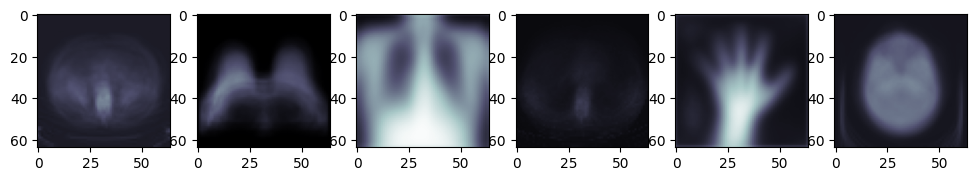

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4)) 
for i in range(6):    
    plt.subplot(1,6, i+1)
    plt.imshow(means[i][0].numpy(), cmap='bone', vmin=0, vmax=1.)

#### DP means

Add the Laplace noise appropriately

In [125]:
from copy import deepcopy
dp_means = deepcopy(means)
for i in range(6):
    dp_means[i] += np.random.laplace(loc=0., scale=b, size=(3,64,64)) 

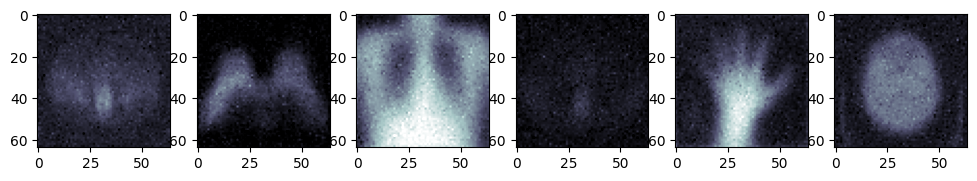

In [126]:
plt.figure(figsize=(12,4)) 
for i in range(6):    
    plt.subplot(1,6, i+1)
    plt.imshow(dp_means[i][2], cmap='bone', vmin=0, vmax=1.)

## Federated DP SGD

## Creating a TrainingPlan

Training Plan is an Object that should occupy one cell of the Notebook.
Its structure is pretty similar to the object we have been using for the centralized training `LocalMedNISTTrainingPlan`.

Please note that in contrary to `LocalMedNISTTrainingPlan`, `MedNISTTrainingPlan` inherits from `fedbiomed.common.training_plans.TorchTrainingPlan`, an object that specify  Node we are using a PyTorch machine learning framework

In [1]:
import torch
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms


# Here we define the model to be used. 

class MedNISTTrainingPlan(TorchTrainingPlan):
    class MyModel(torch.nn.Module):
        """definition of a PyTorch model, with its __init__ and forward methods"""
        def __init__(self, model_args: dict):
            """PyTorch Model definition"""
            super().__init__()
            self.conv1 = nn.Conv2d(3, 64, 3, 1)
            self.conv2 = nn.Conv2d(64, 128, 3, 1)
            self.fc1 = nn.Linear(115200, 6)
    
        def forward(self, x):
            """Model forward pass"""
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)    
    
            output = F.log_softmax(x, dim=1)
            return output
            
    def init_dependencies(self):
        deps = ["from torchvision import datasets",
                "from torchvision.transforms import ToTensor",
                "from monai.transforms import Compose, ScaleIntensity"]

        return deps
    
    def init_model(self, model_args: dict):
        """Defines your model here"""
        return self.MyModel(model_args)

    def init_optimizer(self, optimizer_args):
        """Defines your optimizer here"""
        return torch.optim.SGD(self.model().parameters(), optimizer_args['lr'])

    def training_data(self):
        """Defines data handling/parsing here"""
        # Custom torch Dataloader for MedNIST data

        preprocess = Compose([ToTensor(), ScaleIntensity()])
        train_data = datasets.ImageFolder(self.dataset_path,transform = preprocess)

        return DataManager(dataset=train_data, shuffle=True)
    
    def training_step(self, data, target):
        """Defines cost function and how to compute loss"""
        output = self.model().forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss


In [2]:
batch_size = 48
num_updates = 100
num_rounds = 4

In [3]:
from fedbiomed.researcher.requests import Requests
req = Requests()
query_nodes = req.list()

2023-12-06 10:21:01,148 fedbiomed INFO - Messaging researcher_078531f3-2130-404c-8254-f79b1be9cc1a successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x1417a6ce0>
2023-12-06 10:21:01,209 fedbiomed INFO - Listing available datasets in all nodes... 


In [4]:
min_dataset_size = min([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['tags'] == ['#MEDNIST', '#dataset']]) #see training data in model
tot_dataset_size = sum([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['tags'] == ['#MEDNIST', '#dataset']]) #see training data in model
print(f"Minimum dataset size {min_dataset_size}, Total {tot_dataset_size}")

Minimum dataset size 18000, Total 36000


## (epsilon-delta) DP Parameters

Referring to Section 3.1 of [Abadi et al. (2016)](https://arxiv.org/abs/1607.00133), and setting 1 lot equal to 1 batch, find the definition of the sampling ratio `q`.

Follow section 5.3.2 from [Ponomareva et al. (2023)](https://arxiv.org/abs/2303.00654) to find a suitable value for delta.

Choose a suitable value for epsilon.

In [8]:
epsilon = 10.
q = batch_size/min_dataset_size
delta = 1./np.power(min_dataset_size, 1.1)

Assume that each step satisfies DP with a value of
$$ (q\epsilon, q\delta)$$

Use the composition theorem to compute the total privacy cost after training (including all the rounds and all the updates per round).

Turn this formula around to rescale epsilon and delta, in order to compute an "equivalent epsilon" and "equivalent delta" such that the total training is (epsilon,delta)-DP

In [9]:
equivalent_epochs = num_rounds*num_updates*q
equivalent_epsilon = epsilon/equivalent_epochs
equivalent_delta = delta/equivalent_epochs
print(f"Equivalent epsilon {equivalent_epsilon}, equivalent delta {equivalent_delta}")

Equivalent epsilon 9.375, equivalent delta 1.9551114573931302e-05


For DP-SGD we always use a **Gaussian mechanism**.

Following again Section 3.1 of [Abadi et al. (2016)](https://arxiv.org/abs/1607.00133), find the value of `sigma` needed to ensure that each step satisfies DP with a value of
$$ (q\epsilon, q\delta)$$
with respect to the full database

In [10]:
sigma = np.sqrt(2.*np.log(1.25/equivalent_delta))/equivalent_epsilon
print(f"Sigma: {sigma}")

Sigma: 0.5018011278613237


Set a value for gradient clipping

In [11]:
clip = 0.5

Follow the Fed-BioMed [docs](https://fedbiomed.org/latest/tutorials/security/differential-privacy-with-opacus-on-fedbiomed/) to find out how to enable local DP by setting the proper training arguments

In [12]:
model_args = {
}

n_rounds = num_rounds

training_args = {
    'loader_args': { 
        'batch_size': batch_size, 
    },
    'optimizer_args': {
        'lr': 1e-3
    }, 
    'num_updates': num_updates, 
    'log_interval': 10,
    'dp_args': {
        'type' : 'local', 
        'sigma': sigma, 
        'clip': clip},
}

## Define the Fed-BioMed experiment

And run it.

Optionally, don't forget that you can enable Tensorboard to monitor the progress of your training!

In [13]:
from fedbiomed.researcher.experiment import Experiment

tags =  ['#MEDNIST', '#dataset']

exp = Experiment()



2023-12-06 10:22:00,875 fedbiomed DEBUG - Experiment not fully configured yet: no training data
2023-12-06 10:22:00,876 fedbiomed DEBUG - Experiment not fully configured yet: no node selection strategy
2023-12-06 10:22:00,879 fedbiomed DEBUG - Experiment not fully configured yet: no valid training plan, training_plan_class=None training_plan_class_path=None
2023-12-06 10:22:00,880 fedbiomed DEBUG - Experiment not fully configured yet: no valid training plan, training_plan=None training_plan_path=None
2023-12-06 10:22:00,880 fedbiomed DEBUG - Experiment not fully configured yet: no job. Missing proper training plan definition (training_plan=None training_plan_path=None)
2023-12-06 10:22:00,882 fedbiomed INFO - Removing tensorboard logs from previous experiment


In [14]:
exp.set_model_args(model_args=model_args)
exp.set_training_args(training_args=training_args)

exp.set_round_limit(n_rounds)

4

In [15]:
exp.set_tags(tags)
exp.set_training_plan_class(MedNISTTrainingPlan)
training_data = exp.set_training_data(training_data=None, from_tags=True)
exp.set_job()

2023-12-06 10:22:02,702 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2023-12-06 10:22:12,734 fedbiomed INFO - Node selected for training -> node_040b8e73-337a-4069-b470-4e76732ebf1d
2023-12-06 10:22:12,735 fedbiomed INFO - Node selected for training -> node_b1244528-a3a8-423a-b204-cdba821a2f7c
2023-12-06 10:22:12,736 fedbiomed DEBUG - Training data changed, you may need to update `aggregator`
2023-12-06 10:22:12,767 fedbiomed DEBUG - Model file has been saved: /Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/fedbiomed/var/experiments/Experiment_0034/my_model_a52a919b-18a1-4f96-a030-3144faccd2b5.py
2023-12-06 10:22:12,930 fedbiomed DEBUG - HTTP POST request of file /Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/fedbiomed/var/experiments/Experiment_0034/my_model_a52a919b-18a1-4f96-a030-3144faccd2b5.py successful, with status code 201
Secure RNG turned off. This is perfectly fine for experimentation as it a

In [16]:
from fedbiomed.researcher.aggregators.fedavg import FedAverage
exp.set_aggregator(aggregator=FedAverage)

In [17]:
from fedbiomed.researcher.strategies.default_strategy import DefaultStrategy
exp.set_strategy(node_selection_strategy=DefaultStrategy)

In [18]:
exp.set_tensorboard(True)


True

In [19]:
from fedbiomed.researcher.environ import environ
tensorboard_dir = environ['TENSORBOARD_RESULTS_DIR']

In [20]:
%load_ext tensorboard

In [21]:
tensorboard --logdir "$tensorboard_dir"

In [22]:
exp.run()

2023-12-06 10:35:24,907 fedbiomed INFO - Sampled nodes in round 0 ['node_040b8e73-337a-4069-b470-4e76732ebf1d', 'node_b1244528-a3a8-423a-b204-cdba821a2f7c']
2023-12-06 10:35:24,910 fedbiomed INFO - Sending request 
					 To: node_040b8e73-337a-4069-b470-4e76732ebf1d 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_078531f3-2130-404c-8254-f79b1be9cc1a', 'job_id': 'job_4e9be49a-1031-4ae0-99b9-cf43b9836c3c', 'training_args': {'loader_args': {'batch_size': 48}, 'optimizer_args': {'lr': 0.001}, 'num_updates': 100, 'log_interval': 10, 'dp_args': {'type': 'local', 'sigma': 0.5018011278613237, 'clip': 0.5}, 'epochs': None, 'dry_run': False, 'batch_maxnum': None, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'fedprox_mu': None, 'use_gpu': False, 'share_persistent_buffers': True, 'random_seed': None}, 'training': True, 'model_args': {}, 'round': 0, 'secagg_servkey_id': None, 'se

2023-12-06 10:40:11,721 fedbiomed INFO - TRAINING 
					 NODE_ID: node_040b8e73-337a-4069-b470-4e76732ebf1d 
					 Round 1 | Iteration: 90/100 (90%) | Samples: 4424/4800
 					 Loss: 1.790046 
					 ---------
2023-12-06 10:40:22,239 fedbiomed INFO - TRAINING 
					 NODE_ID: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Round 1 | Iteration: 100/100 (100%) | Samples: 4665/4800
 					 Loss: 1.788445 
					 ---------
2023-12-06 10:40:22,242 fedbiomed INFO - WARNING
					 NODE node_b1244528-a3a8-423a-b204-cdba821a2f7c
					 MESSAGE: save_state method of optimizer not implemented, cannot save optimizer status
-----------------------------------------------------------------
2023-12-06 10:40:22,243 fedbiomed INFO - WARNING
					 NODE node_b1244528-a3a8-423a-b204-cdba821a2f7c
					 MESSAGE: Unable to save optimizer state of type <class 'fedbiomed.common.optimizers.generic_optimizers.NativeTorchOptimizer'>. Skipping...
-----------------------------------------------------------------
2023-12

2023-12-06 10:41:20,012 fedbiomed INFO - TRAINING 
					 NODE_ID: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Round 2 | Iteration: 10/100 (10%) | Samples: 495/4800
 					 Loss: 1.788986 
					 ---------
2023-12-06 10:41:20,225 fedbiomed INFO - TRAINING 
					 NODE_ID: node_040b8e73-337a-4069-b470-4e76732ebf1d 
					 Round 2 | Iteration: 10/100 (10%) | Samples: 496/4800
 					 Loss: 1.789059 
					 ---------
2023-12-06 10:41:46,082 fedbiomed INFO - TRAINING 
					 NODE_ID: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Round 2 | Iteration: 20/100 (20%) | Samples: 979/4800
 					 Loss: 1.787604 
					 ---------
2023-12-06 10:41:48,212 fedbiomed INFO - TRAINING 
					 NODE_ID: node_040b8e73-337a-4069-b470-4e76732ebf1d 
					 Round 2 | Iteration: 20/100 (20%) | Samples: 1021/4800
 					 Loss: 1.791213 
					 ---------
2023-12-06 10:42:12,738 fedbiomed INFO - TRAINING 
					 NODE_ID: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Round 2 | Iteration: 30/100 (30%) | Samples: 1464/48

2023-12-06 10:45:36,194 fedbiomed DEBUG - researcher_078531f3-2130-404c-8254-f79b1be9cc1a
2023-12-06 10:45:36,196 fedbiomed INFO - Sending request 
					 To: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_078531f3-2130-404c-8254-f79b1be9cc1a', 'job_id': 'job_4e9be49a-1031-4ae0-99b9-cf43b9836c3c', 'training_args': {'loader_args': {'batch_size': 48}, 'optimizer_args': {'lr': 0.001}, 'num_updates': 100, 'log_interval': 10, 'dp_args': {'type': 'local', 'sigma': 0.5018011278613237, 'clip': 0.5}, 'epochs': None, 'dry_run': False, 'batch_maxnum': None, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'fedprox_mu': None, 'use_gpu': False, 'share_persistent_buffers': True, 'random_seed': None}, 'training': True, 'model_args': {}, 'round': 2, 'secagg_servkey_id': None, 'secagg_biprime_id': None, 'secagg_random': None, 'secagg_clipping_ran

2023-12-06 10:50:31,550 fedbiomed INFO - WARNING
					 NODE node_b1244528-a3a8-423a-b204-cdba821a2f7c
					 MESSAGE: save_state method of optimizer not implemented, cannot save optimizer status
-----------------------------------------------------------------
2023-12-06 10:50:31,552 fedbiomed INFO - WARNING
					 NODE node_b1244528-a3a8-423a-b204-cdba821a2f7c
					 MESSAGE: Unable to save optimizer state of type <class 'fedbiomed.common.optimizers.generic_optimizers.NativeTorchOptimizer'>. Skipping...
-----------------------------------------------------------------
2023-12-06 10:50:31,917 fedbiomed INFO - Downloading model params after training on node_040b8e73-337a-4069-b470-4e76732ebf1d - from http://localhost:8844/media/uploads/2023/12/06/node_params_e2f9f1e6-d3ce-4331-a429-e81da0ae476e.mpk
2023-12-06 10:50:32,176 fedbiomed DEBUG - download of file node_params_cd6899ba-ebd7-4a77-a56b-07c63f8af4a8.mpk successful, with status code 200
2023-12-06 10:50:32,280 fedbiomed INFO - INFO
			

2023-12-06 10:52:42,094 fedbiomed INFO - TRAINING 
					 NODE_ID: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Round 4 | Iteration: 40/100 (40%) | Samples: 1973/4800
 					 Loss: 1.769227 
					 ---------
2023-12-06 10:53:07,414 fedbiomed INFO - TRAINING 
					 NODE_ID: node_040b8e73-337a-4069-b470-4e76732ebf1d 
					 Round 4 | Iteration: 50/100 (50%) | Samples: 2434/4800
 					 Loss: 1.774007 
					 ---------
2023-12-06 10:53:08,363 fedbiomed INFO - TRAINING 
					 NODE_ID: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Round 4 | Iteration: 50/100 (50%) | Samples: 2437/4800
 					 Loss: 1.775452 
					 ---------
2023-12-06 10:53:36,243 fedbiomed INFO - TRAINING 
					 NODE_ID: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Round 4 | Iteration: 60/100 (60%) | Samples: 2929/4800
 					 Loss: 1.773930 
					 ---------
2023-12-06 10:53:36,298 fedbiomed INFO - TRAINING 
					 NODE_ID: node_040b8e73-337a-4069-b470-4e76732ebf1d 
					 Round 4 | Iteration: 60/100 (60%) | Samples: 2940

4

## 3.2. Gather trained model

Now we are going to retrieve the trained model from the `Experiment`

In [68]:
trained_model = exp.training_plan().model()
trained_model.load_state_dict(exp.aggregated_params()[n_rounds - 1]['params'])

<All keys matched successfully>

## 3.3. Get confusion matrix using the testing dataset

Now we will use the testing dataset to get the confusion matrix


In [69]:
test_loss, test_accuracy, test_cm = testing_accuracy(trained_model, test_dl)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████| 177/177 [01:59<00:00,  1.48it/s]


Test loss = 0.18
Test accuracy = 96.44%


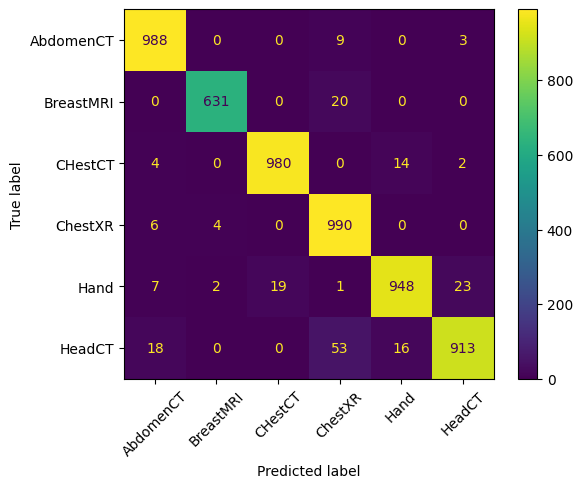

In [70]:
print(f"Test loss = {test_loss:.2f}")
print(f"Test accuracy = {test_accuracy:.2f}%")

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm,
                            display_labels=[labels_name[i] for i in range(6)])

disp.plot(xticks_rotation=45)
plt.show()

## Renyi DP - Privacy accounting

We will now compute the privacy budget spent **using the same parameters as above**, but under the framework of Renyi DP instead of epsilon,delta-DP. 


Fix an array of orders 
$$\alpha = [1,2,5,10,10^2,10^3,10^6]$$

(Note: see [this SO answer](https://crypto.stackexchange.com/a/90264) as well as Definition 3 of [Mironov (2017)](https://arxiv.org/abs/1702.07476) for an interpretation of alpha)

Given 

$$\sigma, \epsilon, q$$

Aa defined above, we will use the RDP accountant implementation of Tensorflow to compute the equivalent privacy budget spent.

In [23]:
import urllib.request
response = urllib.request.urlopen('https://raw.githubusercontent.com/tensorflow/privacy/7eea74a6a1cf15e2d2bd890722400edd0e470db8/research/hyperparameters_2022/rdp_accountant.py')
rdp_accountant = response.read()
exec(rdp_accountant)

In [41]:
orders = np.array([1.001, 1.01, 1.1, 1.25, 2, 5, 10])
rdp = compute_rdp(q, sigma, equivalent_epochs, orders)
epsilon_spent_rdp, delta_spent_rdp, optimal_order = get_privacy_spent(orders, rdp, target_eps=None, target_delta=equivalent_delta)
print(f"Privacy spent epsilon: {epsilon_spent_rdp} delta: {delta_spent_rdp} optimal order: {optimal_order}")

Privacy spent epsilon: 4.7728547711218425 delta: 1.9551114573931302e-05 optimal order: 5.0


In [42]:
print(f"Spent budget for (epsilon-delta)-DP: {epsilon:.6f}, {delta:.6f}")
print(f"Spent budget for Renyi-DP: {epsilon_spent_rdp:.6f}, {delta_spent_rdp:.6f}")

Spent budget for (epsilon-delta)-DP: 10.000000, 0.000021
Spent budget for Renyi-DP: 4.772855, 0.000020


Convert Renyi-DP into (epsilon,delta)-DP using the formula provided [here](https://programming-dp.com/ch8.html#renyi-differential-privacy)

In [44]:
converted_eps = epsilon_spent_rdp + (np.log(1./delta))/(optimal_order - 1.)

In [45]:
print(f"Spent budget for (epsilon-delta)-DP converted from Renyi: {converted_eps:.6f}, {delta:.6f}")

Spent budget for (epsilon-delta)-DP converted from Renyi: 7.467340, 0.000021


The converted value for epsilon is still smaller than the originally accounted value using our naive composition formula. 

Find a paragraph [here](https://programming-dp.com/ch8.html#renyi-differential-privacy) that corroborates this finding, and try to explain it in your own words.